In [53]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import progressbar
import re
from scipy.stats import f_oneway
from scipy.stats  import chisquare
from time import sleep
import folium

In [5]:
lat=51.517094
long=-0.088761
url = 'https://data.police.uk/api/crimes-street/all-crime?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()
crime_df=pd.DataFrame()
pb = progressbar.ProgressBar()
for date in pb(date_range):
    crime = requests.get(url.format(lat,long,date))
    crime=crime.json()
    crime_df=crime_df.append(crime)
    sleep(0.4)
crime_df.reset_index(drop=True,inplace=True)

100% |########################################################################|


In [6]:
crime_df.to_csv('crime.csv')

In [8]:
crime_df['latitude'] = crime_df['location'].apply(lambda x:x['latitude'])
crime_df['longitude'] = crime_df['location'].apply(lambda x:x['longitude'])
crime_df['date_outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x:x['date'])
crime_df['outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x: x['category'])
crime_df = crime_df.drop(columns=['location','location_type','context','outcome_status','persistent_id','id','location_subtype'])

In [10]:
lat=51.517094
long=-0.088761

url = 'https://data.police.uk/api/stops-street?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()
stopsearch_df=pd.DataFrame()
pb = progressbar.ProgressBar()
for date in pb(date_range):
    stopsearch = requests.get(url.format(lat,long,date))
    stopsearch=stopsearch.json()
    stopsearch_df=stopsearch_df.append(stopsearch)
    
stopsearch_df.reset_index(drop=True,inplace=True)

100% |########################################################################|


In [11]:
stopsearch_df.to_csv('stopsearch.csv')

In [12]:
stopsearch_df['latitude'] = stopsearch_df['location'].apply(lambda x:x['latitude'])
stopsearch_df['longitude'] = stopsearch_df['location'].apply(lambda x:x['longitude'])
stopsearch_df['outcome_name'] = stopsearch_df[~stopsearch_df['outcome_object'].isna()]['outcome_object'].apply(lambda x: x['name'])
stopsearch_df.head(2)

age_range                                  outcome  involved_person  \
0   over 34                         Suspect arrested             True   
1     25-34  Offender given drugs possession warning             True   

                           self_defined_ethnicity gender  \
0                      White - White British (W1)   Male   
1  Mixed - Any other Mixed ethnic background (M9)   Male   

                             legislation outcome_linked_to_object_of_search  \
0  Misuse of Drugs Act 1971 (section 23)                               True   
1  Misuse of Drugs Act 1971 (section 23)                               True   

                    datetime removal_of_more_than_outer_clothing  \
0  2016-12-02T23:20:00+00:00                               False   
1  2016-12-02T21:37:00+00:00                               False   

                                      outcome_object  \
0       {'id': 'arrest', 'name': 'Suspect arrested'}   
1  {'id': 'drugs', 'name': 'Offender given drugs ...   

                                            location operation  \
0  {'latitude': '51.525800', 'street': {'id': 148...      None   
1  {'latitude': '51.525800', 'street': {'id': 148...      None   

  officer_defined_ethnicity           type operation_name  object_of_search  \
0                     White  Person search           None  Controlled drugs   
1                     White  Person search           None  Controlled drugs   

    latitude  longitude                             outcome_name  
0  51.525800  -0.087601                         Suspect arrested  
1  51.525800  -0.087601  Offender given drugs possession warning

In [13]:
stopsearch_df['self_defined_ethnicity'] = stopsearch_df['self_defined_ethnicity'].apply(lambda x:re.split('/|,| ',str(x))[0])

In [14]:
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].isin(['Not','None']),'self_defined_ethnicity']='Other'
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].str.startswith('Chinese'),'self_defined_ethnicity']='Asian'

In [15]:
stopsearch_df = stopsearch_df[['age_range','involved_person','self_defined_ethnicity',
               'gender','datetime','officer_defined_ethnicity','object_of_search','latitude',
              'longitude','outcome_name']]

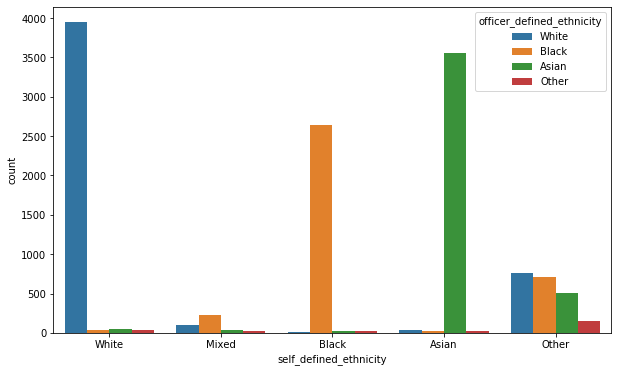

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data = stopsearch_df, x = 'self_defined_ethnicity', hue='officer_defined_ethnicity')
plt.show()

In [17]:
#Local authority	White	Mixed	Asian	Black	Other
#City of London	78.6	3.9	12.7	2.6	2.1

In [18]:
crime_df['crime_severity'] = crime_df['category'].map({'anti-social-behaviour' : 5, 'bicycle-theft' : 15, 'burglary' : 465,
       'criminal-damage-arson' : 442, 'drugs' : 9, 'other-theft' : 37,
       'possession-of-weapons': 71, 'public-order': 73, 'robbery': 800, 'shoplifting': 12,
       'theft-from-the-person': 80, 'vehicle-crime': 9, 'violent-crime': 1447,
       'other-crime': 5})

In [19]:
crime_df['crime_month'] = pd.DatetimeIndex(crime_df['month']).month

In [24]:
f_oneway(list(crime_df[crime_df['crime_month'].isin([3,4,5])]['crime_severity']),
        list(crime_df[crime_df['crime_month'].isin([6,7,8])]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin([9,10,11])]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin([12,1,2])]['crime_severity']))

F_onewayResult(statistic=2.169319628630795, pvalue=0.08935620196776364)

In [25]:
f_oneway(list(crime_df[crime_df['crime_month'].isin([3,4,5,6])]['crime_severity']),
        list(crime_df[crime_df['crime_month'].isin([7,8,9,10])]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin([11,12,1,2])]['crime_severity']))

F_onewayResult(statistic=5.43669040155633, pvalue=0.0043551567917107)

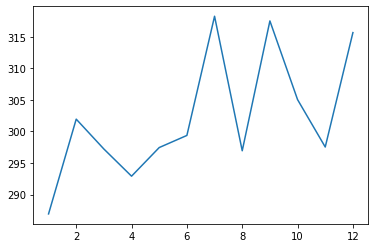

In [20]:
plt.plot(crime_df.groupby('crime_month')['crime_severity'].mean())

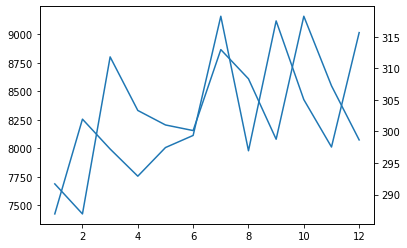

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(crime_df.groupby('crime_month')['crime_severity'].count())
ax2 = ax1.twinx()
ax2.plot(crime_df.groupby('crime_month')['crime_severity'].mean())

In [39]:
crime_df['outcome'].unique()

array([nan, 'Investigation complete; no suspect identified',
       'Status update unavailable', 'Offender given community sentence',
       'Offender sent to prison', 'Court result unavailable',
       'Unable to prosecute suspect', 'Defendant found not guilty',
       'Offender given absolute discharge',
       'Offender given penalty notice', 'Offender given a caution',
       'Local resolution', 'Offender fined',
       'Offender given a drugs possession warning',
       'Offender deprived of property',
       'Offender given conditional discharge',
       'Formal action is not in the public interest',
       'Offender given suspended prison sentence',
       'Further investigation is not in the public interest',
       'Court case unable to proceed', 'Offender otherwise dealt with',
       'Offender ordered to pay compensation',
       'Action to be taken by another organisation',
       'Suspect charged as part of another case',
       'Awaiting court outcome', 'Defendant sent to

In [40]:
no_suspect=crime_df[crime_df['outcome']=='Investigation complete; no suspect identified']

In [41]:
no_suspect

category    month   latitude  longitude date_outcome  \
495    bicycle-theft  2016-12  51.518949  -0.092297      2016-12   
496    bicycle-theft  2016-12  51.514204  -0.106922      2017-01   
498    bicycle-theft  2016-12  51.514204  -0.106922      2017-01   
500    bicycle-theft  2016-12  51.515100  -0.085669      2016-12   
501    bicycle-theft  2016-12  51.516966  -0.100884      2017-02   
...              ...      ...        ...        ...          ...   
99582  violent-crime  2019-11  51.521567  -0.097334      2019-11   
99594  violent-crime  2019-11  51.514276  -0.087549      2019-11   
99671  violent-crime  2019-11  51.514204  -0.106922      2019-11   
99686  violent-crime  2019-11  51.513865  -0.092625      2019-11   
99853  violent-crime  2019-11  51.519976  -0.066063      2019-11   

                                             outcome  crime_severity  \
495    Investigation complete; no suspect identified              15   
496    Investigation complete; no suspect identified              15   
498    Investigation complete; no suspect identified              15   
500    Investigation complete; no suspect identified              15   
501    Investigation complete; no suspect identified              15   
...                                              ...             ...   
99582  Investigation complete; no suspect identified            1447   
99594  Investigation complete; no suspect identified            1447   
99671  Investigation complete; no suspect identified            1447   
99686  Investigation complete; no suspect identified            1447   
99853  Investigation complete; no suspect identified            1447   

       crime_month  
495             12  
496             12  
498             12  
500             12  
501             12  
...            ...  
99582           11  
99594           11  
99671           11  
99686           11  
99853           11  

[24109 rows x 8 columns]

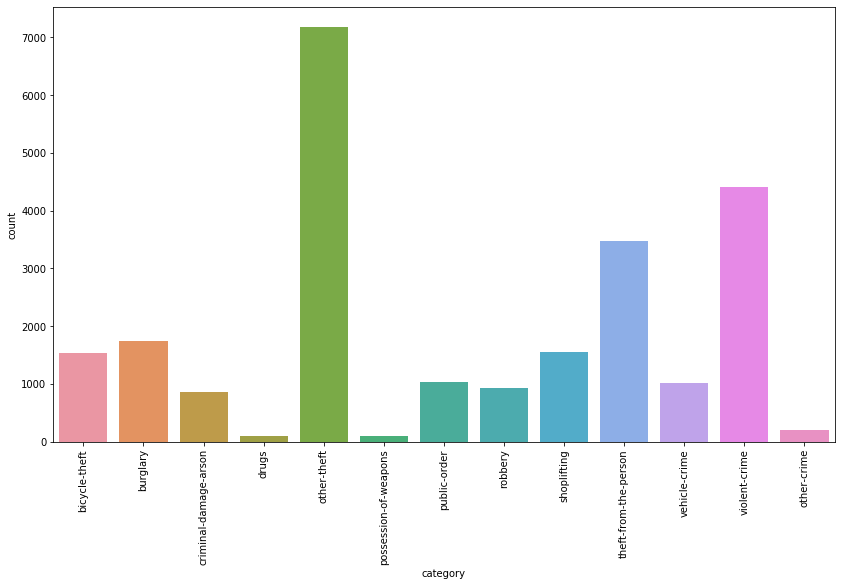

In [42]:
plt.figure(figsize=(14,8))
sns.countplot(no_suspect['category'])
plt.xticks(rotation=90)
plt.show()

In [44]:
mask1=crime_df['crime_severity']>100
mask2=crime_df['outcome'] =='Investigation complete; no suspect identified'

In [45]:
a1=len(crime_df[mask1&mask2])
a2=len(crime_df[~mask1 & mask2])
a3=len(crime_df[mask1 & ~mask2])
a4=len(crime_df[~mask1 & ~mask2])

In [50]:
f_obs = np.array([[a1,a2],[a3,a4]])

In [52]:
f_obs

array([[ 7943, 16166],
       [17858, 57975]])

In [58]:
chisquare(f_obs)

Power_divergenceResult(statistic=array([ 3810.20987559, 23576.59703808]), pvalue=array([0., 0.]))

In [63]:
#Actual
a1=len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='White'])*100/len(stopsearch_df)
a2=len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Black'])*100/len(stopsearch_df)
a3=len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Asian'])*100/len(stopsearch_df)
a4=len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Mixed'])*100/len(stopsearch_df)
a5=len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Other'])*100/len(stopsearch_df)

In [66]:
#Expected
e1=59.79
e2=13.32
e3=18.49
e4=4.96
e5=3.44

In [72]:
f_obs=np.array([a1,a2,a3,a4,a5])
f_exp=np.array([e1,e2,e3,e4,e5])

In [73]:
chisquare(f_obs,f_exp)

Power_divergenceResult(statistic=83.13425013318803, pvalue=3.7731257057129753e-17)